# Credit Card Fraud Detection with Concept Drift Adaptation

This notebook demonstrates the experiments of anomaly (fraud) detection in real-world data of credit card transactions. These experiments are run as part of the MSc thesis "Stream Learning for Anomaly Detection with Concept Drift Adaptation: Applications to Credit Card Fraud Detection" by Loredana Sandu, submitted to the Open University of Catalonia in 2024 as part of the Master in Computational and Mathematical Engineering.

**Table of contents:**
- [1. Loading the data](#toc1)
- [2. Dimensionality reduction](#toc2)
    - [2.1. Principal Component Analysis (PCA)](#toc21)
    - [2.2. t-Distributed Stochastic Neighbor Embedding (t-SNE)](#toc22)
    - [2.3. Uniform Manifold Approximation and Projection (UMAP)](#toc23)
- [3. Anomaly detection algorithms (without concept drift adaptation)](#toc3)    
    - [3.1. Baseline algorithms without hyperparameter tuning](#toc31)    
    - [3.2. Algorithms with hyperparameter tuning](#toc32)
- [4. Concept drift detection algorithms](#toc4)    
- [5. Anomaly detection algorithms with concept drift adaptation](#toc5)

In [4]:
from river import stream
from river import anomaly
from river import metrics
from river import drift
from river import utils
from river import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import umap.plot

from tqdm import tqdm

np.random.seed(42)

c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='toc1'></a>1. Loading the data

In [5]:
df = pd.read_csv('data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
pd.merge(df.value_counts('Class'), df.value_counts('Class', normalize=True), on='Class')

,count,proportion
Class,,
0,284315,0.998273
1,492,0.001727


<Axes: >

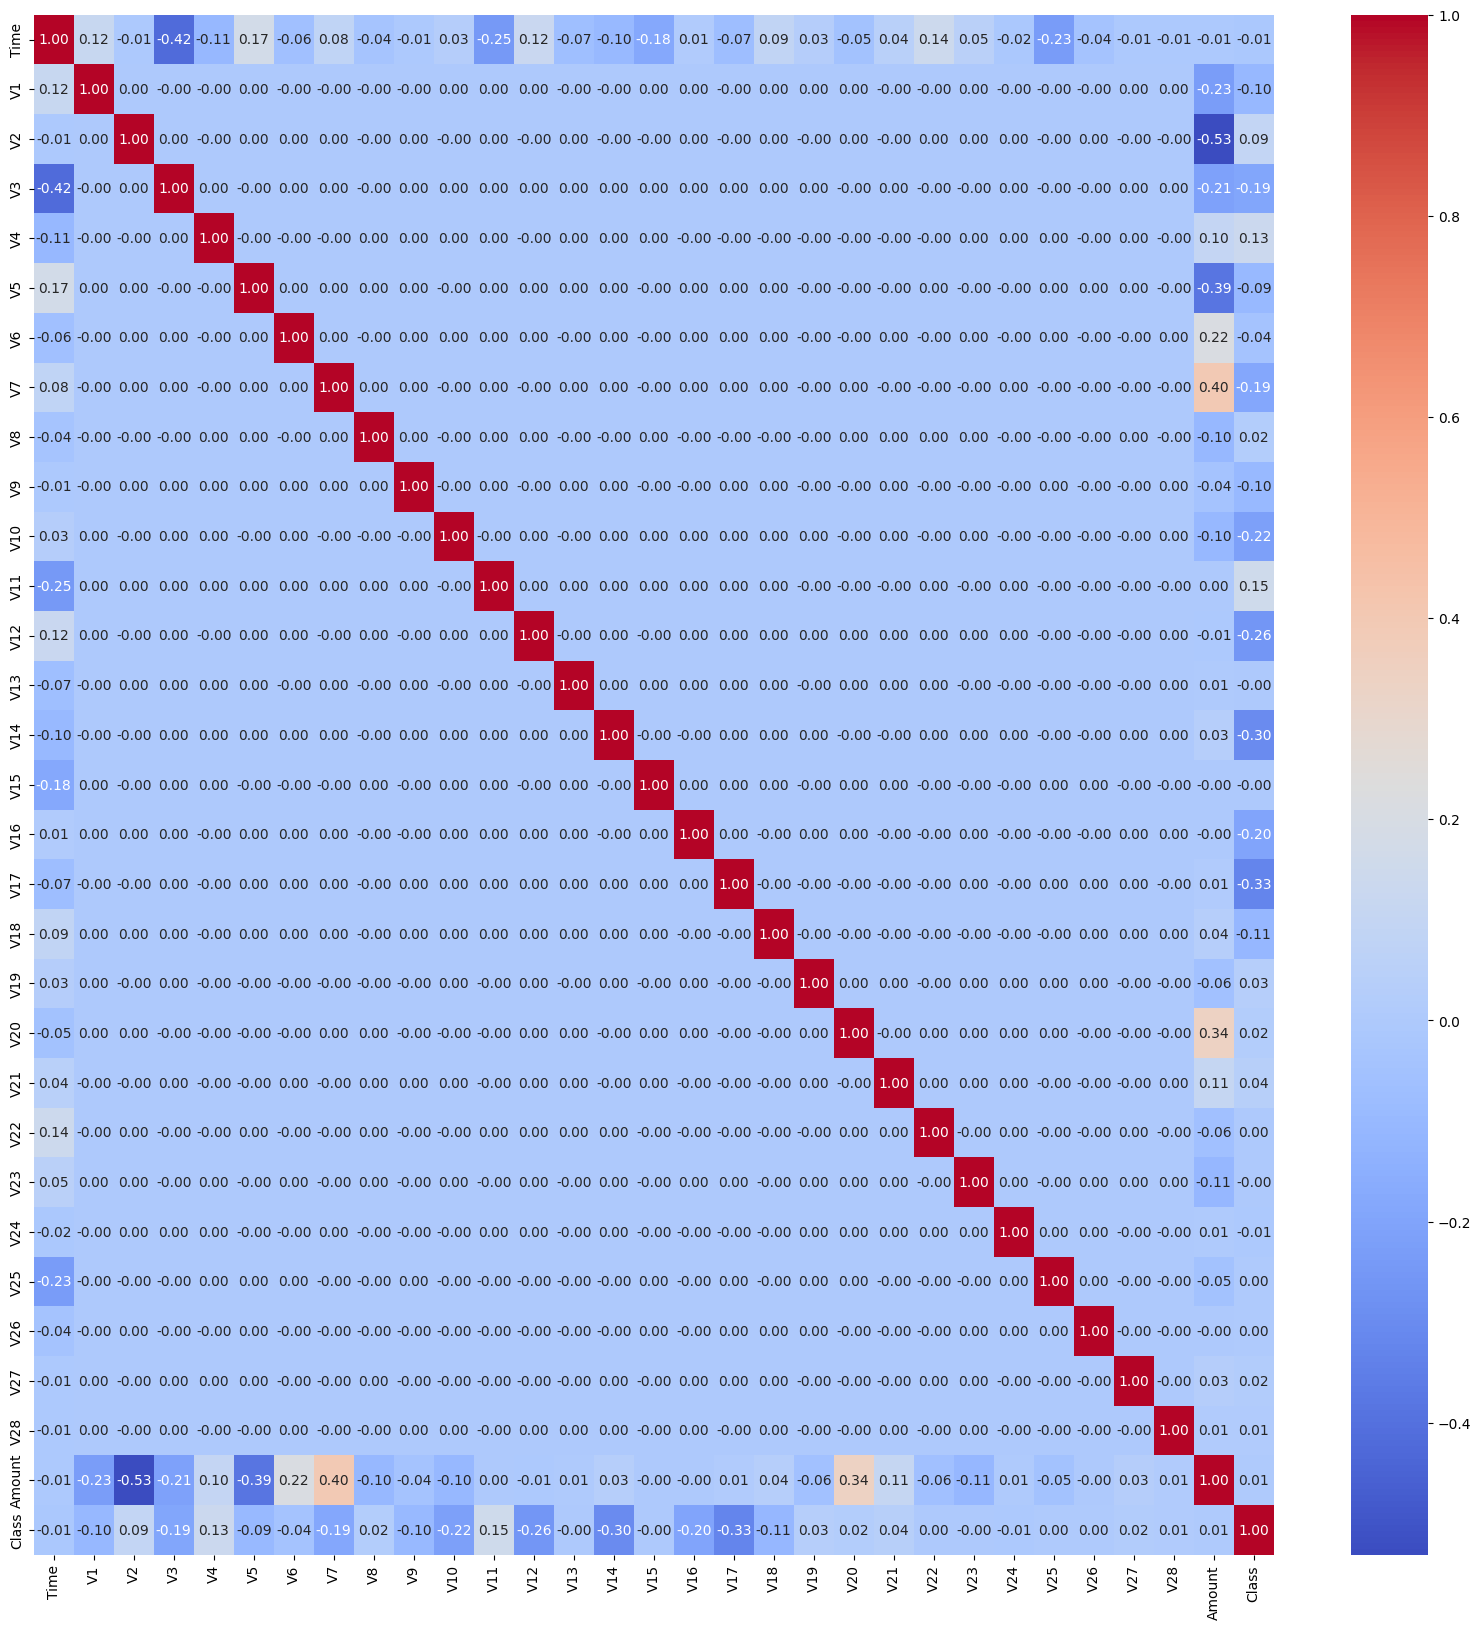

In [7]:
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

## <a id='toc2'></a>2. Dimensionality Reduction

### 2.1. Principal Component Analysis (PCA)

In [8]:
# take the features and the target
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class'].reset_index(drop=True)

# apply PCA
pca = PCA(n_components=2, random_state=42)
X = pca.fit_transform(X)

# show the result
df_PCA = pd.DataFrame(data=X, columns=['PCA1', 'PCA2'])
df_PCA['Class'] = y

df_PCA.head()

,PCA1,PCA2,Class
0,61.271382,1.319433,0
1,-85.661826,-1.043988,0
2,290.316696,0.810555,0
3,35.151659,0.928317,0
4,-18.360281,1.317420,0


<Axes: xlabel='PCA1', ylabel='PCA2'>

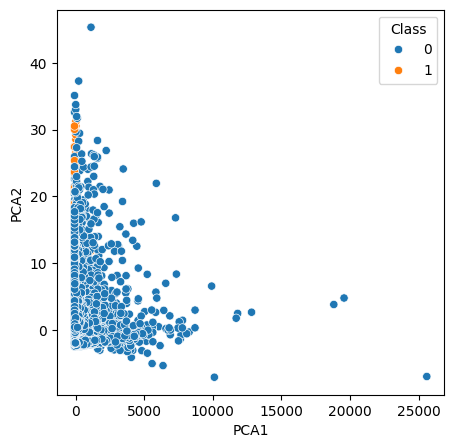

In [9]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='Class', data=df_PCA, hue_order=[0,1])

<Axes: >

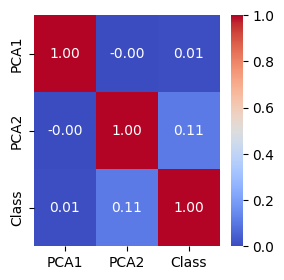

In [10]:
# Correlation matrix
corr_matrix = df_PCA.corr()
plt.figure(figsize=(3, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

### 2.2. t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [11]:
# take the features and the target
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class'].reset_index(drop=True)

# apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X)

# show the result
df_TSNE = pd.DataFrame(data=tsne_results, columns=['t-SNE1', 't-SNE2'])
df_TSNE['Class'] = y

df_TSNE

,t-SNE1,t-SNE2,Class
0,77.206261,-1.013854,0
1,-89.355942,9.581004,0
2,90.142105,32.464970,0
3,62.156422,46.001541,0
4,37.596157,21.141439,0
...,...,...,...
284802,-5.096301,90.134697,0
284803,-9.892531,-17.307306,0
284804,25.376963,27.966202,0
284805,-14.897339,35.595066,0


<Axes: xlabel='t-SNE1', ylabel='t-SNE2'>

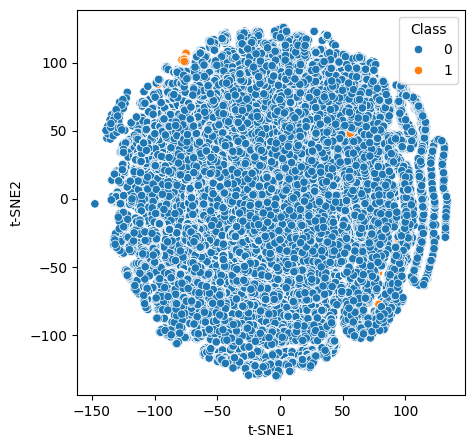

In [12]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Class', data=df_TSNE)

<Axes: >

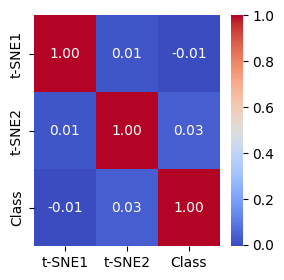

In [13]:
# Correlation matrix
corr_matrix = df_TSNE.corr()
plt.figure(figsize=(3, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

### 2.3. Uniform Manifold Approximation and Projection (UMAP)

In [14]:
# take the features and the target
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class'].reset_index(drop=True)

# apply UMAP
mapper = umap.UMAP(n_components=2, random_state=42).fit(X)

# save the result
umap_results = mapper.transform(X)
df_UMAP = pd.DataFrame(data=umap_results, columns=['UMAP1', 'UMAP2'])
df_UMAP['Class'] = y

df_UMAP

c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,UMAP1,UMAP2,Class
0,-0.222245,-5.608180,0
1,-4.837699,5.193599,0
2,6.378217,-13.238727,0
3,2.617977,-5.619156,0
4,1.454683,0.743973,0
...,...,...,...
284802,8.425257,0.946381,0
284803,4.804154,5.036674,0
284804,4.950806,9.824841,0
284805,7.673502,2.018580,0


<Axes: >

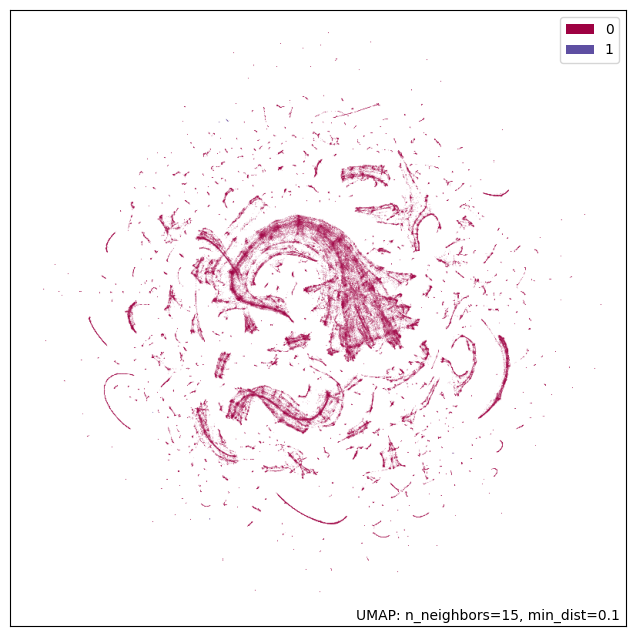

In [15]:
umap.plot.points(mapper, labels=y, width=800, height=800)

<Axes: >

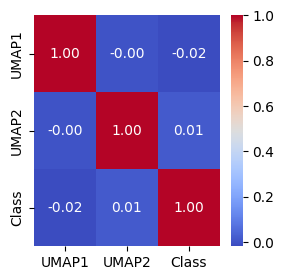

In [16]:
# Correlation matrix
corr_matrix = df_UMAP.corr()
plt.figure(figsize=(3, 3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

## <a id='toc3'></a>3. Anomaly detection algorithms (without concept drift adaptation)

In [33]:
def run_and_evaluate_model(scaler, model, X, y, progress_bar=True):
    """
    Run the scaler and the model on the data and evaluate its performance.

    INPUTS:
    - scaler: the scaler to normalize the data
    - model: river.anomaly.base.AnomalyDetector, the anomaly detection model
    - X: pd.DataFrame containing the features
    - y: pd.Series containing the labels
    - progress_bar: bool, whether to show a progress bar or not

    OUTPUTS:
    - metrics_results: dict, the results of the evaluated metrics
    """
    precision = metrics.Precision()
    recall = metrics.Recall()
    f1 = metrics.F1()
    balanced_accuracy = metrics.BalancedAccuracy()
    rocauc = metrics.ROCAUC()
    rolling_rocauc = metrics.RollingROCAUC(window_size=1000)

    metrics_results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'balanced_accuracy': [],
        'rocauc': [],
        'rolling_rocauc': []
    }

    if progress_bar:
        data_stream = tqdm(stream.iter_pandas(X, y), total=len(X))
    else:
        data_stream = stream.iter_pandas(X, y)

    for x, y in data_stream:

        scaler.learn_one(x)
        x = scaler.transform_one(x)

        try:
            score = model.score_one(x)
        except:
            score = model.score_one(x, y)

        is_anomaly = model.classify(score)

        try:
            model.learn_one(x)
        except:
            model.learn_one(x, y)

        rocauc.update(y, score)
        precision.update(y, is_anomaly)
        recall.update(y, is_anomaly)
        f1.update(y, is_anomaly)
        balanced_accuracy.update(y, is_anomaly)
        rolling_rocauc.update(y, score)

        metrics_results['precision'].append(precision.get())
        metrics_results['recall'].append(recall.get())
        metrics_results['f1'].append(f1.get())
        metrics_results['balanced_accuracy'].append(balanced_accuracy.get())
        metrics_results['rocauc'].append(rocauc.get())
        metrics_results['rolling_rocauc'].append(rolling_rocauc.get())

    return metrics_results

In [34]:
features = df.drop(['Time', 'Class'], axis=1)
target = df['Class']

PCA_features = df_PCA.drop('Class', axis=1)
TSNE_features = df_TSNE.drop('Class', axis=1)
UMAP_features = df_UMAP.drop('Class', axis=1)

### <a id='toc31'></a>3.1. Baseline algorithms without hyperparameter tuning

#### Half-Space Trees on the original data

In [39]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(seed=42),
    q=0.99
)

X = features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:32<00:00, 3084.60it/s]

Precision: 5.88
Recall: 0.81
F1 Score: 1.43
Balanced accuracy: 50.40
ROCAUC: 91.23


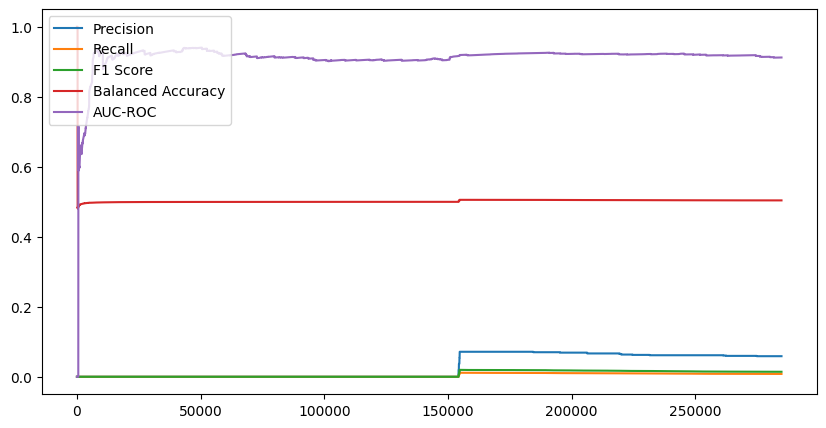

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Half-Space Trees on the PCA data

In [42]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(seed=42),
    q=0.99
)

X = PCA_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:23<00:00, 3420.41it/s]

Precision: 4.47
Recall: 17.89
F1 Score: 7.16
Balanced accuracy: 58.61
ROCAUC: 78.91


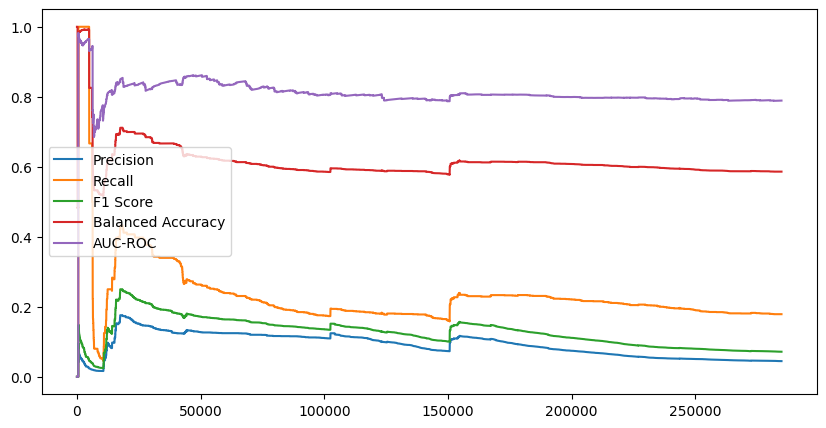

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Half-Space Trees on the t-SNE data

In [44]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(seed=42),
    q=0.99
)

X = TSNE_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [03:17<00:00, 1445.13it/s]


Precision: 7.99
Recall: 20.73
F1 Score: 11.54
Balanced accuracy: 60.16
ROCAUC: 51.57


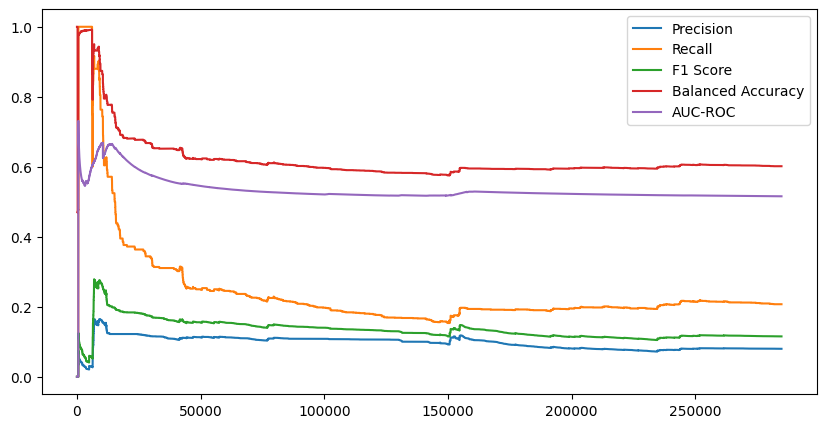

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Half-Space Trees on the UMAP data

In [46]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(seed=42),
    q=0.99
)

X = UMAP_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [03:19<00:00, 1427.80it/s]

Precision: 6.31
Recall: 35.57
F1 Score: 10.72
Balanced accuracy: 67.33
ROCAUC: 60.72


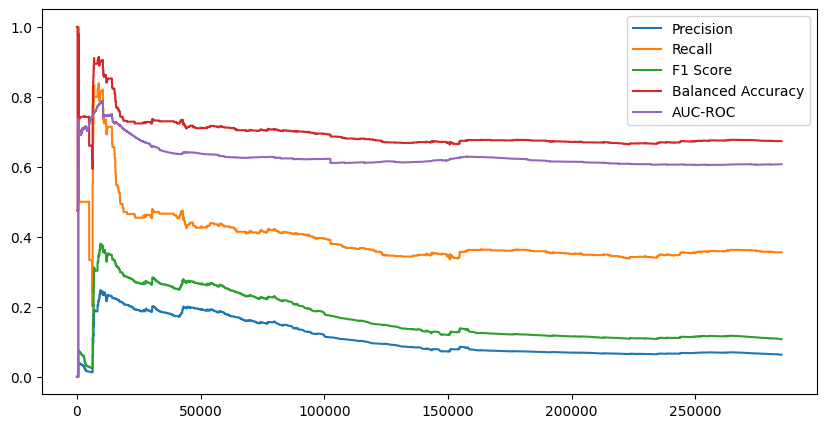

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### One-Class SVM on the original data

In [48]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(),
    q=0.99
)

X = features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:09<00:00, 4078.36it/s]

Precision: 0.03
Recall: 2.24
F1 Score: 0.06
Balanced accuracy: 44.75
ROCAUC: 0.49


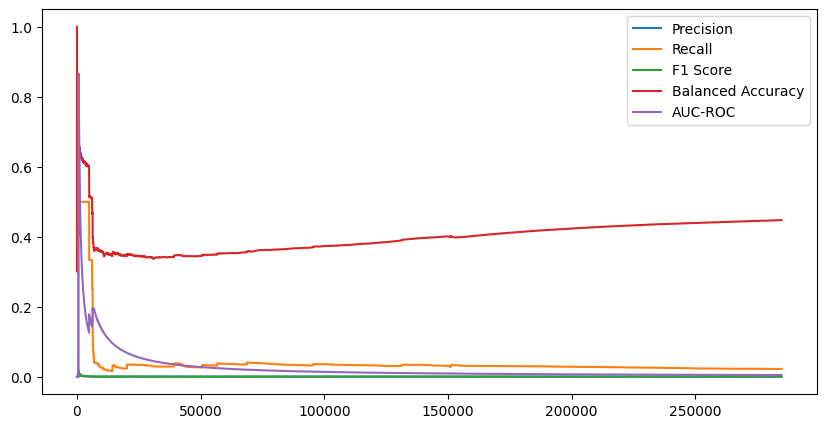

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### One-Class SVM on the PCA data

In [50]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(),
    q=0.99
)

X = PCA_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:00<00:00, 4701.67it/s]

Precision: 5.91
Recall: 9.35
F1 Score: 7.24
Balanced accuracy: 54.55
ROCAUC: 50.00


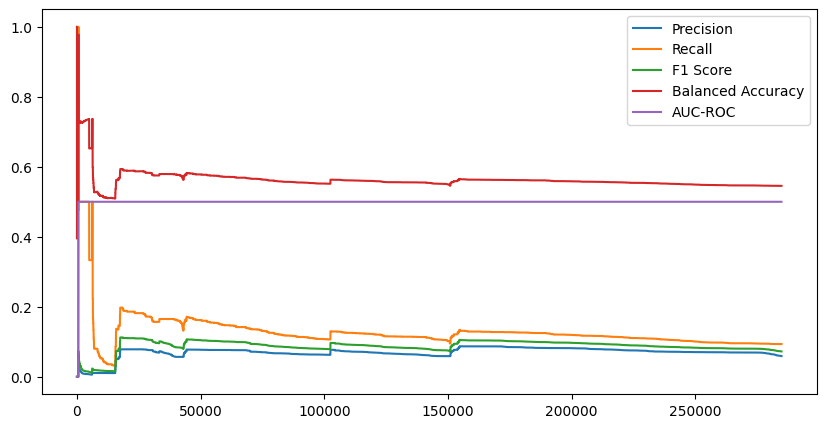

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### One-Class SVM on the t-SNE data

In [52]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(),
    q=0.99
)

X = TSNE_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:59<00:00, 4815.65it/s]

Precision: 0.15
Recall: 0.41
F1 Score: 0.22
Balanced accuracy: 49.97
ROCAUC: 70.47


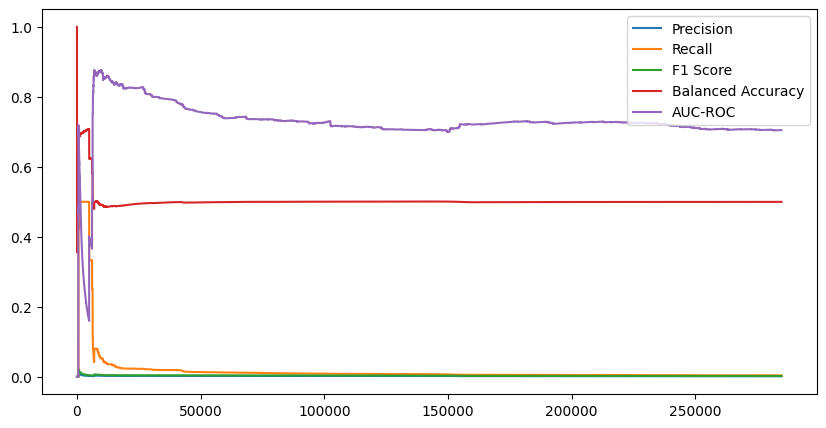

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### One-Class SVM on the UMAP data

In [54]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(),
    q=0.99
)

X = UMAP_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:58<00:00, 4862.85it/s]

Precision: 0.13
Recall: 0.81
F1 Score: 0.22
Balanced accuracy: 49.85
ROCAUC: 51.68


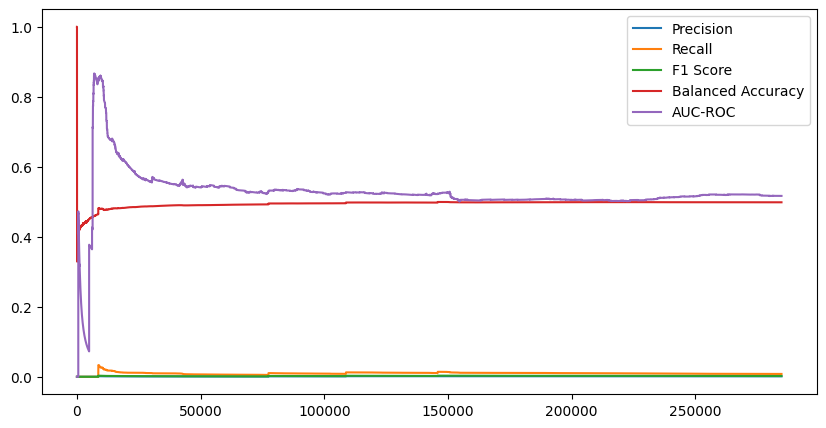

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Gaussian Scorer on the original data

In [56]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(),
    q=0.99
)

X = features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/284807 [00:00<?, ?it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
100%|██████████| 284807/284807 [00:43<00:00, 6608.29it/s]

Precision: 99.39
Recall: 99.80
F1 Score: 99.59
Balanced accuracy: 99.90
ROCAUC: 99.84


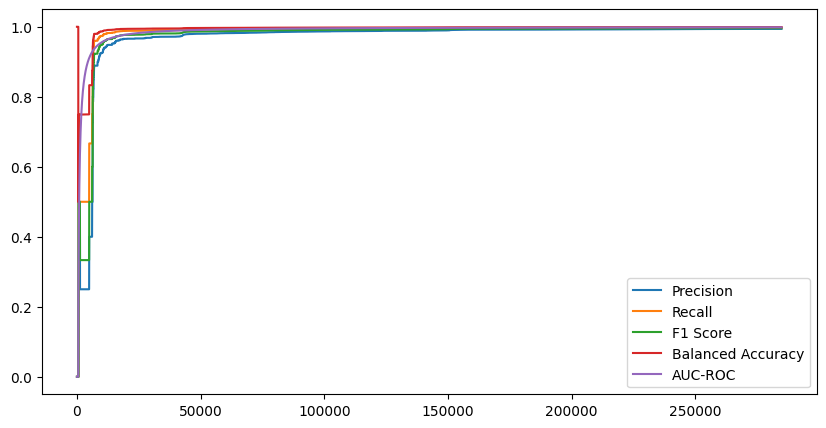

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Gaussian Scorer on the PCA data

In [ ]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(),
    q=0.99
)

X = PCA_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

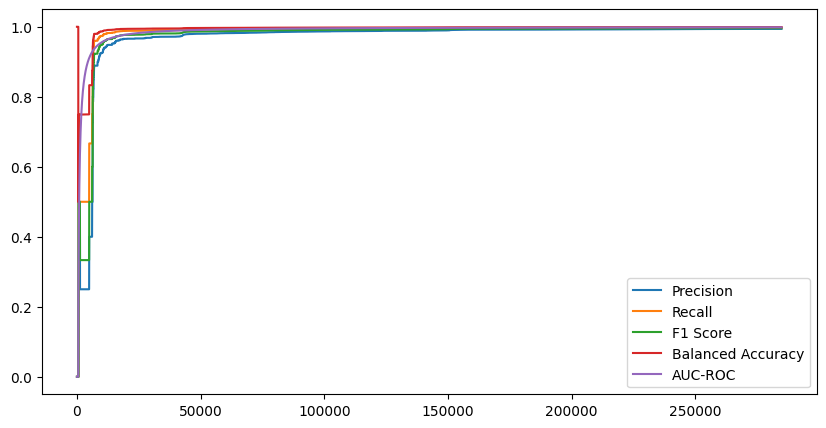

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Gaussian Scorer on the t-SNE data

In [59]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(),
    q=0.99
)

X = TSNE_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:35<00:00, 8023.74it/s]


Precision: 99.39
Recall: 99.80
F1 Score: 99.59
Balanced accuracy: 99.90
ROCAUC: 99.84


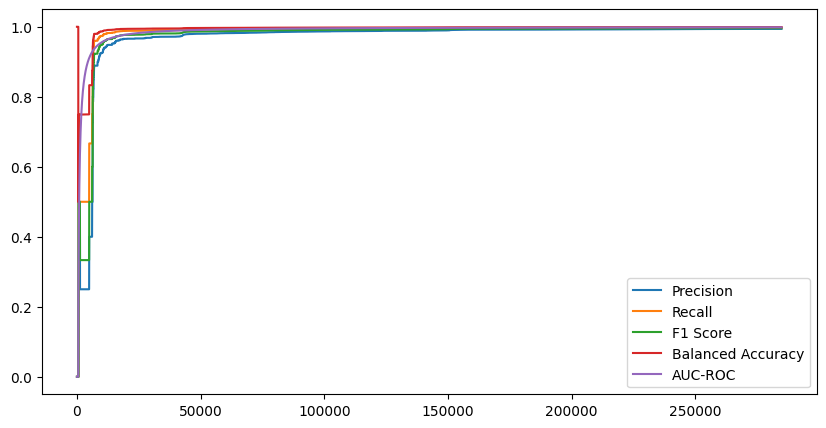

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Gaussian Scorer on the UMAP data

In [61]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(),
    q=0.99
)

X = UMAP_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:35<00:00, 8080.19it/s]

Precision: 99.39
Recall: 99.80
F1 Score: 99.59
Balanced accuracy: 99.90
ROCAUC: 99.84


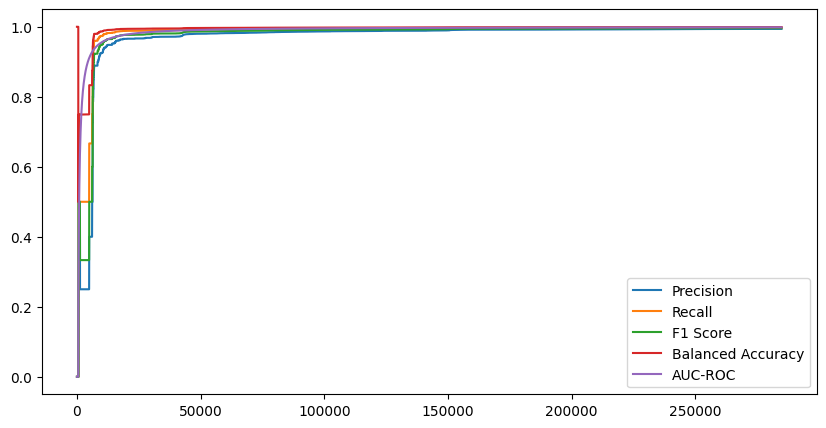

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Local Outlier Factor

This model has been tested and it is too slow to run. It has been tried with different dataset sizes distance functions and number of neighbors, but it is still too slow. Therefore, it is commented out and not included in the final experiments.

In [63]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly.LocalOutlierFactor(n_neighbors=2),
    q=0.95
)

X = features.copy()
y = target.copy()

# metrics_results = run_and_evaluate_model(scaler, model, X, y)

### <a id='toc32'></a>3.2. Algorithms with hyperparameter tuning

#### Half-Space Trees

In [64]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.HalfSpaceTrees(),
    q=0.95
)

X = features.copy()
y = target.copy()

grid = {
    'anomaly_detector': [
        (anomaly.HalfSpaceTrees, {
            'seed':[42],
            'n_trees': [5, 10, 20],
            'height': [3, 5, 10],
            'window_size': [50, 100, 250]
        })
    ],
    'q': [0.95, 0.99]
}

models = utils.expand_param_grid(model, grid)
print("Number of models to test: ", len(models))

best_metric = -1
best_model = None
for model in models:
    metrics_results = run_and_evaluate_model(scaler, model, X, y, progress_bar=False)

    final_precision = metrics_results['precision'][-1]
    final_recall = metrics_results['recall'][-1]
    final_f1 = metrics_results['f1'][-1]
    final_balanced_accuracy = metrics_results['balanced_accuracy'][-1]
    final_rocauc = metrics_results['rocauc'][-1]

    composite_score = 0.1*final_precision + 0.1*final_recall + 0.1*final_f1 + 0.35*final_balanced_accuracy + 0.35*final_rocauc

    if composite_score > best_metric:
        best_metric = composite_score
        best_model = model

Number of models to test:  54


In [65]:
best_model

QuantileFilter (
  anomaly_detector=HalfSpaceTrees (
    n_trees=20
    height=3
    window_size=250
    limits=defaultdict(..., {'Amount': (0.0, 1.0), 'V1': (0.0, 1.0), 'V10': (0.0, 1.0), 'V11': (0.0, 1.0), 'V12': (0.0, 1.0), 'V13': (0.0, 1.0), 'V14': (0.0, 1.0), 'V15': (0.0, 1.0), 'V16': (0.0, 1.0), 'V17': (0.0, 1.0), 'V18': (0.0, 1.0), 'V19': (0.0, 1.0), 'V2': (0.0, 1.0), 'V20': (0.0, 1.0), 'V21': (0.0, 1.0), 'V22': (0.0, 1.0), 'V23': (0.0, 1.0), 'V24': (0.0, 1.0), 'V25': (0.0, 1.0), 'V26': (0.0, 1.0), 'V27': (0.0, 1.0), 'V28': (0.0, 1.0), 'V3': (0.0, 1.0), 'V4': (0.0, 1.0), 'V5': (0.0, 1.0), 'V6': (0.0, 1.0), 'V7': (0.0, 1.0), 'V8': (0.0, 1.0), 'V9': (0.0, 1.0)})
    seed=42
  )
  q=0.99
  protect_anomaly_detector=True
)

#### Fine-Tuned Half-Space Trees on the original data

In [83]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/284807 [00:00<?, ?it/s]

100%|██████████| 284807/284807 [01:46<00:00, 2684.11it/s]

Precision: 41.86
Recall: 25.61
F1 Score: 31.78
Balanced accuracy: 62.77
ROCAUC: 88.78


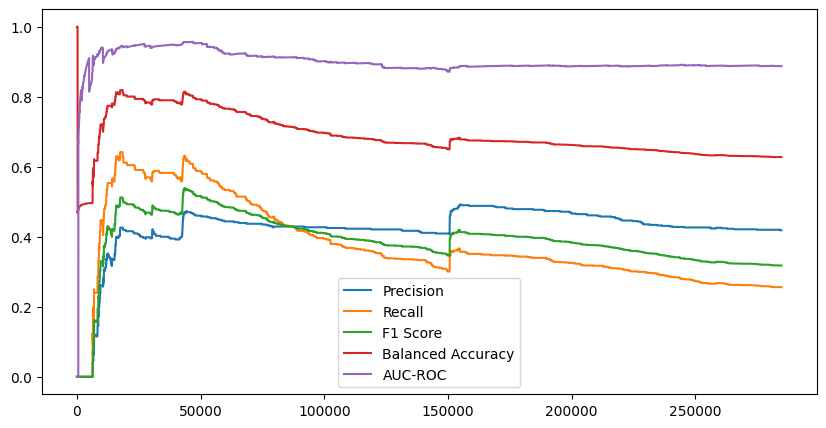

In [84]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned Half-Space Trees on the PCA data

In [85]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = PCA_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:29<00:00, 3172.49it/s]


Precision: 12.98
Recall: 11.79
F1 Score: 12.35
Balanced accuracy: 55.83
ROCAUC: 73.18


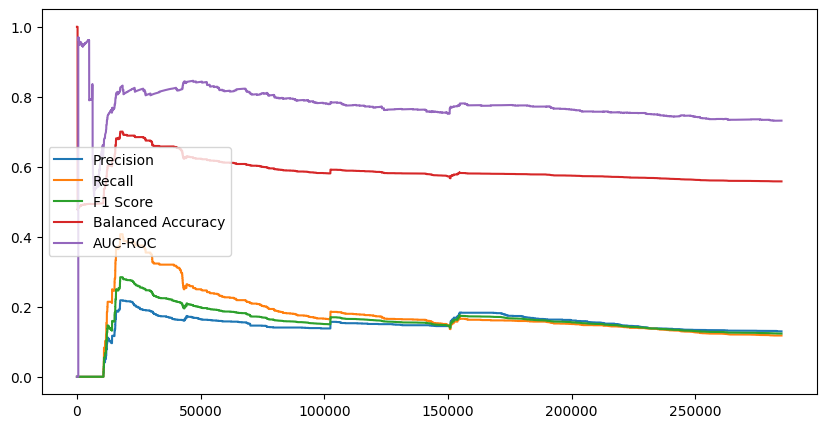

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned Half-Space Trees on the t-SNE data

In [87]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = TSNE_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [03:34<00:00, 1327.24it/s]

Precision: 4.86
Recall: 21.34
F1 Score: 7.91
Balanced accuracy: 60.31
ROCAUC: 68.62


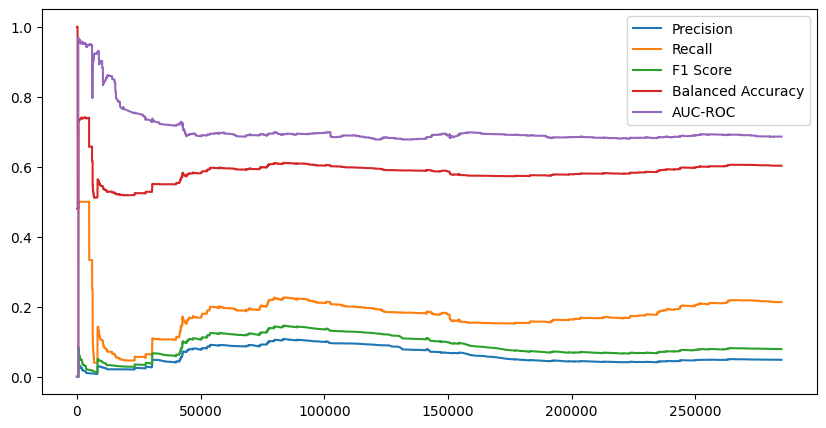

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned Half-Space Trees on the UMAP data

In [89]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = UMAP_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [03:33<00:00, 1333.44it/s]

Precision: 1.68
Recall: 2.85
F1 Score: 2.11
Balanced accuracy: 51.28
ROCAUC: 71.81


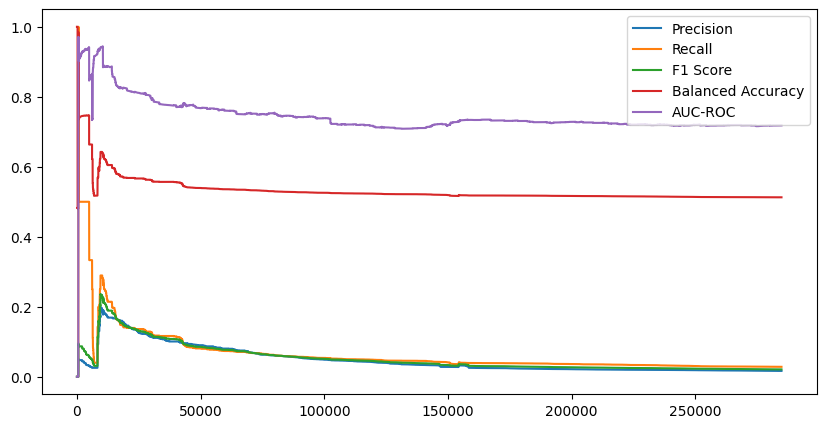

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### One-Class SVM

In [68]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.OneClassSVM(),
    q=0.95
)

X = features.copy()
y = target.copy()

grid = {
    'anomaly_detector': [
        (anomaly.OneClassSVM, {
            'nu': [0.001, 0.002, 0.005, 0.01, 0.05]
        })
    ],
    'q': [0.9, 0.95, 0.99]
}

models = utils.expand_param_grid(model, grid)
print("Number of models to test: ", len(models))

best_metric = -1
best_model = None
for model in models:
    metrics_results = run_and_evaluate_model(scaler, model, X, y, progress_bar=False)

    final_precision = metrics_results['precision'][-1]
    final_recall = metrics_results['recall'][-1]
    final_f1 = metrics_results['f1'][-1]
    final_balanced_accuracy = metrics_results['balanced_accuracy'][-1]
    final_rocauc = metrics_results['rocauc'][-1]

    composite_score = 0.1*final_precision + 0.1*final_recall + 0.1*final_f1 + 0.35*final_balanced_accuracy + 0.35*final_rocauc

    if composite_score > best_metric:
        best_metric = composite_score
        best_model = model

Number of models to test:  15


In [69]:
best_model

QuantileFilter (
  anomaly_detector=OneClassSVM (
    nu=0.001
    optimizer=SGD (
      lr=Constant (
        learning_rate=0.01
      )
    )
    intercept_lr=Constant (
      learning_rate=0.01
    )
    clip_gradient=1e+12
    initializer=Zeros ()
  )
  q=0.95
  protect_anomaly_detector=True
)

#### Fine-Tuned One-Class SVM on the original data

In [91]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:22<00:00, 3438.96it/s]

Precision: 0.09
Recall: 28.05
F1 Score: 0.18
Balanced accuracy: 37.65
ROCAUC: 36.28


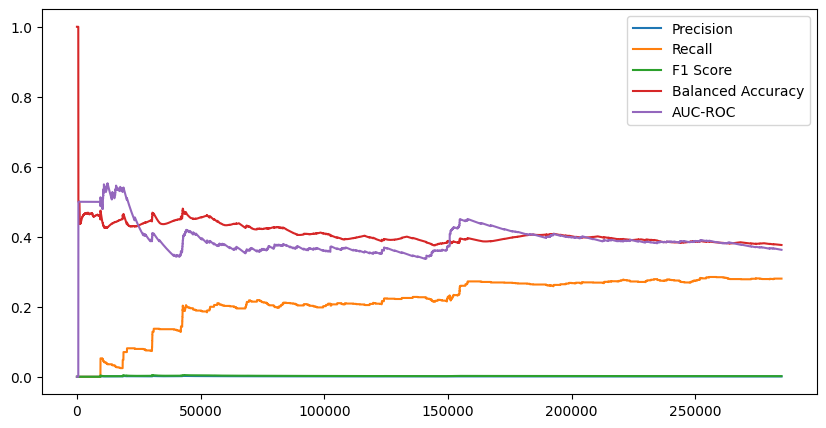

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned One-Class SVM on the PCA data

In [93]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = PCA_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:15<00:00, 3766.38it/s]


Precision: 0.75
Recall: 55.08
F1 Score: 1.48
Balanced accuracy: 71.23
ROCAUC: 50.00


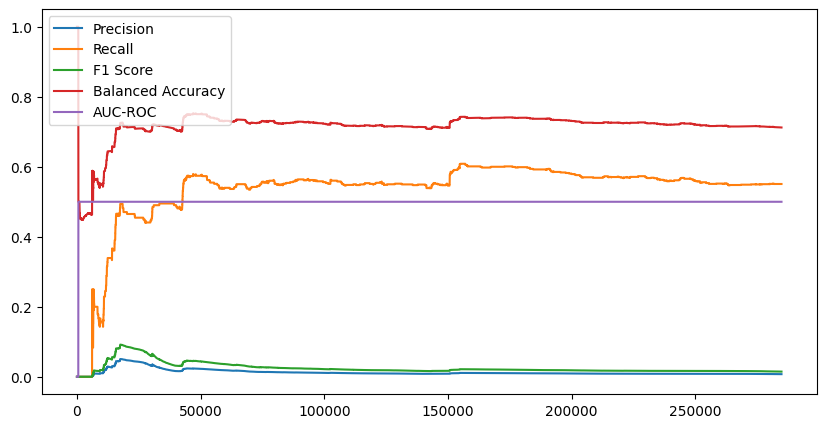

In [94]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned One-Class SVM on the t-SNE data

In [95]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = TSNE_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:17<00:00, 3681.31it/s]


Precision: 0.27
Recall: 34.76
F1 Score: 0.53
Balanced accuracy: 56.20
ROCAUC: 50.03


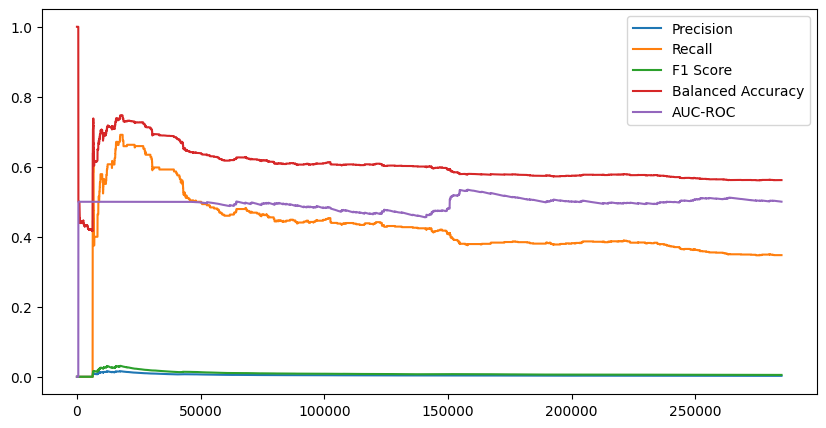

In [96]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned One-Class SVM on the UMAP data

In [97]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = UMAP_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:15<00:00, 3784.68it/s]

Precision: 0.27
Recall: 35.37
F1 Score: 0.54
Balanced accuracy: 56.55
ROCAUC: 42.60


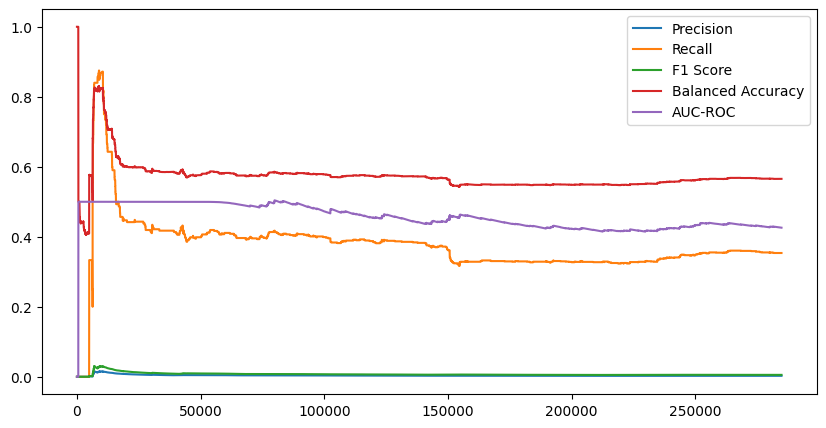

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Gaussian Scorer

In [72]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.GaussianScorer(),
    q=0.95
)

X = features.copy()
y = target.copy()

grid = {
    'anomaly_detector': [
        (anomaly.GaussianScorer, {
            'window_size': [None, 1, 25, 50, 100, 250, 500, 1000]
        })
    ],
    'q': [0.9, 0.95, 0.99]
}

models = utils.expand_param_grid(model, grid)
print("Number of models to test: ", len(models))

best_metric = -1
best_model = None
for model in models:
    metrics_results = run_and_evaluate_model(scaler, model, X, y, progress_bar=False)

    final_precision = metrics_results['precision'][-1]
    final_recall = metrics_results['recall'][-1]
    final_f1 = metrics_results['f1'][-1]
    final_balanced_accuracy = metrics_results['balanced_accuracy'][-1]
    final_rocauc = metrics_results['rocauc'][-1]

    composite_score = 0.1*final_precision + 0.1*final_recall + 0.1*final_f1 + 0.35*final_balanced_accuracy + 0.35*final_rocauc

    if composite_score > best_metric:
        best_metric = composite_score
        best_model = model

Number of models to test:  24


c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))


In [73]:
best_model

QuantileFilter (
  anomaly_detector=GaussianScorer (
    window_size=None
    grace_period=100
  )
  q=0.99
  protect_anomaly_detector=True
)

#### Fine-Tuned Gaussian Scorer on the original data

In [105]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:53<00:00, 5279.18it/s]

Precision: 99.39
Recall: 99.80
F1 Score: 99.59
Balanced accuracy: 99.90
ROCAUC: 99.84


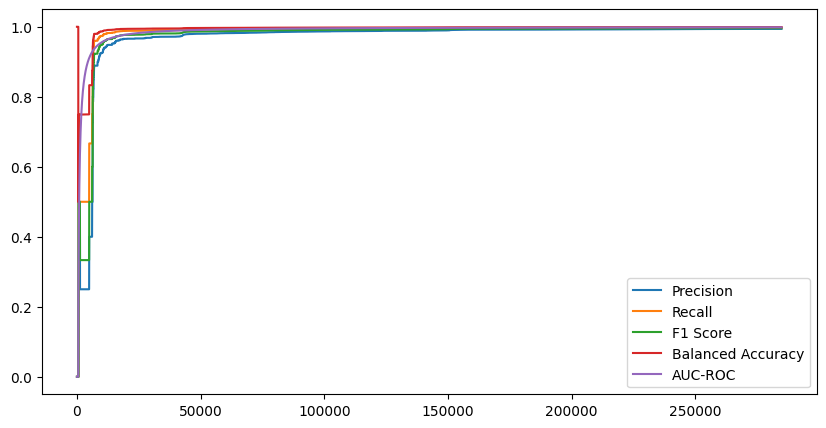

In [106]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned Gaussian Scorer on the PCA data

In [99]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = PCA_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/284807 [00:00<?, ?it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
100%|██████████| 284807/284807 [00:44<00:00, 6444.90it/s]

Precision: 99.39
Recall: 99.80
F1 Score: 99.59
Balanced accuracy: 99.90
ROCAUC: 99.84


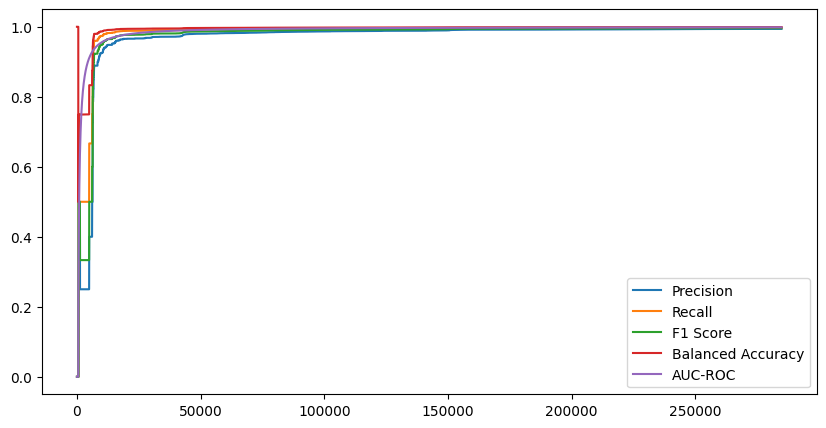

In [100]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned Gaussian Scorer on the TSNE data

In [101]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = TSNE_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:44<00:00, 6403.09it/s]

Precision: 99.39
Recall: 99.80
F1 Score: 99.59
Balanced accuracy: 99.90
ROCAUC: 99.84


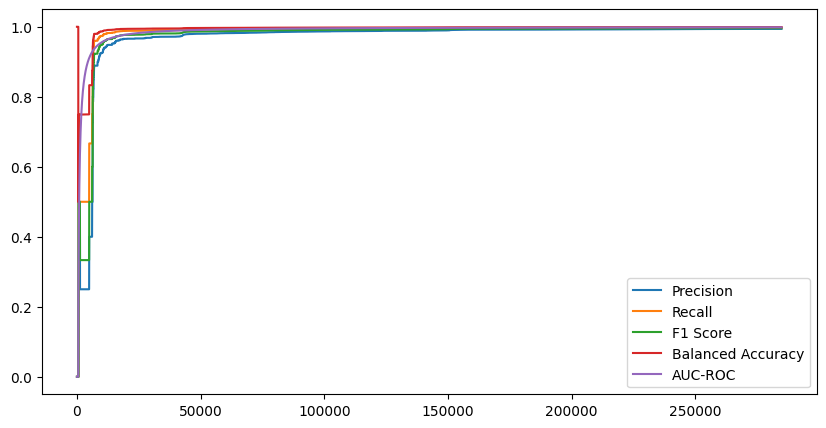

In [102]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

#### Fine-Tuned Gaussian Scorer on the UMAP data

In [103]:
scaler = preprocessing.MinMaxScaler()

model = anomaly.QuantileFilter(
    anomaly_detector=anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = UMAP_features.copy()
y = target.copy()

metrics_results = run_and_evaluate_model(scaler, model, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:44<00:00, 6463.86it/s]

Precision: 99.39
Recall: 99.80
F1 Score: 99.59
Balanced accuracy: 99.90
ROCAUC: 99.84


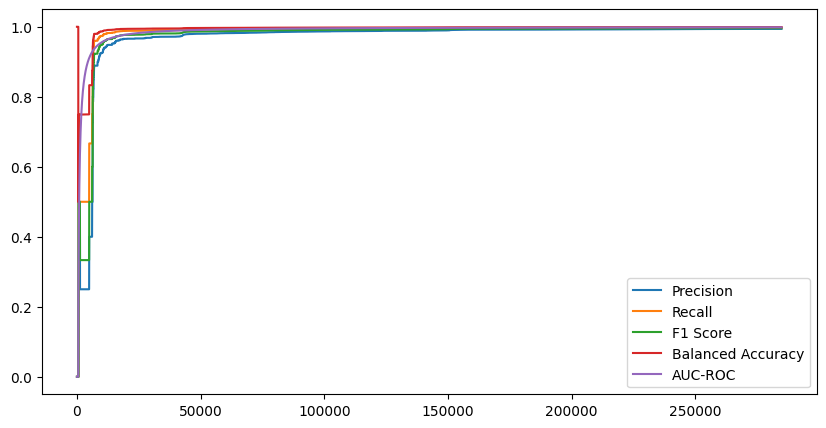

In [104]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
plt.legend()
plt.show()

## <a id='toc5'></a>5. Concept drift detection algorithms

#### ADWIN

In [80]:
X = features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}
drifts = []

for i, x in tqdm(enumerate(X.values), total=len(X)):
    for j, x_j in enumerate(x):
        drift_detectors[X.columns[j]].update(x_j)

    colums_drift_detected = [X.columns[j] for j in range(len(X.columns)) if drift_detectors[X.columns[j]].drift_detected]

    if len(colums_drift_detected) >= 1:
            drifts.append(i)

print("Change detected at indices:", drifts)
print("Number of changes detected:", len(drifts))

100%|██████████| 284807/284807 [00:51<00:00, 5547.86it/s]

Change detected at indices: [10207, 13503, 14335, 19327, 19423, 20479, 24543, 25247, 28671, 32767, 75935, 84447, 95807, 99039, 105919, 107519, 115391, 122879, 125087, 126975, 129023, 130463, 130783, 132287, 142271, 145759, 146399, 146847, 146879, 147455, 148095, 148191, 148895, 148927, 149151, 149503, 149983, 150207, 151359, 152479, 153311, 153503, 153535, 153983, 154911, 157663, 157887, 160127, 160255, 160735, 161215, 162431, 163647, 163775, 163839, 165311, 167743, 167903, 169695, 171423, 173471, 173663, 173759, 180223, 190943, 201119, 223263, 237919, 240639, 242303, 249663, 261503, 264063, 271967, 272863, 273407, 274815, 278527, 280863, 282431]
Number of changes detected: 80


In [81]:
X = PCA_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}
drifts = []

for i, x in tqdm(enumerate(X.values), total=len(X)):
    for j, x_j in enumerate(x):
        drift_detectors[X.columns[j]].update(x_j)

    colums_drift_detected = [X.columns[j] for j in range(len(X.columns)) if drift_detectors[X.columns[j]].drift_detected]

    if len(colums_drift_detected) >= 1:
            drifts.append(i)

print("Change detected at indices:", drifts)
print("Number of changes detected:", len(drifts))

100%|██████████| 284807/284807 [00:06<00:00, 43150.46it/s]

Change detected at indices: [28799, 32767, 105919, 158399, 173663, 223935, 271967]
Number of changes detected: 7


In [107]:
X = TSNE_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}
drifts = []

for i, x in tqdm(enumerate(X.values), total=len(X)):
    for j, x_j in enumerate(x):
        drift_detectors[X.columns[j]].update(x_j)

    colums_drift_detected = [X.columns[j] for j in range(len(X.columns)) if drift_detectors[X.columns[j]].drift_detected]

    if len(colums_drift_detected) >= 1:
            drifts.append(i)

print("Change detected at indices:", drifts)
print("Number of changes detected:", len(drifts))

100%|██████████| 284807/284807 [00:05<00:00, 51248.32it/s]

Change detected at indices: [14335, 19487, 64543, 101407, 129023, 131039, 152959, 159711, 174047, 239615, 277759]
Number of changes detected: 11


In [108]:
X = UMAP_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}
drifts = []

for i, x in tqdm(enumerate(X.values), total=len(X)):
    for j, x_j in enumerate(x):
        drift_detectors[X.columns[j]].update(x_j)

    colums_drift_detected = [X.columns[j] for j in range(len(X.columns)) if drift_detectors[X.columns[j]].drift_detected]

    if len(colums_drift_detected) >= 1:
            drifts.append(i)

print("Change detected at indices:", drifts)
print("Number of changes detected:", len(drifts))

100%|██████████| 284807/284807 [00:06<00:00, 43236.75it/s]

Change detected at indices: [14335, 15359, 145407, 167935, 279679]
Number of changes detected: 5


#### Page-Hinkley

In [112]:
drift_detectors = {feature: drift.PageHinkley(delta=1e-10) for feature in X.columns}
drifts = []

for i, x in tqdm(enumerate(X.values), total=len(X)):
    for j, x_j in enumerate(x):
        drift_detectors[X.columns[j]].update(x_j)

    colums_drift_detected = [X.columns[j] for j in range(len(X.columns)) if drift_detectors[X.columns[j]].drift_detected]

    if len(colums_drift_detected) >= 1:
            drifts.append(i)

print("Change detected at indices:", drifts)
print("Number of changes detected:", len(drifts))

100%|██████████| 284807/284807 [00:04<00:00, 65631.14it/s]

Change detected at indices: [29, 30, 80, 89, 148, 149, 183, 188, 229, 269, 305, 321, 365, 387, 401, 434, 441, 473, 499, 550, 556, 586, 632, 651, 683, 694, 727, 809, 815, 847, 850, 877, 882, 916, 919, 949, 956, 998, 1003, 1031, 1054, 1118, 1189, 1238, 1263, 1290, 1325, 1362, 1386, 1419, 1452, 1505, 1512, 1555, 1607, 1644, 1649, 1700, 1703, 1758, 1770, 1875, 1885, 1925, 1955, 2033, 2047, 2079, 2136, 2159, 2192, 2230, 2252, 2275, 2315, 2339, 2369, 2399, 2433, 2469, 2485, 2515, 2521, 2546, 2551, 2594, 2620, 2627, 2650, 2657, 2707, 2746, 2752, 2779, 2794, 2811, 2832, 2863, 2881, 2911, 2936, 2957, 3000, 3037, 3059, 3091, 3135, 3179, 3182, 3209, 3276, 3282, 3312, 3341, 3352, 3425, 3426, 3459, 3492, 3519, 3561, 3600, 3606, 3641, 3644, 3683, 3690, 3772, 3787, 3834, 3838, 3877, 3906, 3926, 3938, 3969, 3983, 4065, 4098, 4127, 4134, 4157, 4165, 4194, 4224, 4255, 4286, 4294, 4336, 4366, 4390, 4420, 4444, 4453, 4513, 4518, 4564, 4635, 4675, 4727, 4840, 4884, 4930, 4995, 5027, 5044, 5088, 5097, 5126,

## <a id='toc5'></a>5. Anomaly detection algorithms with concept drift adaptation

In [19]:
def run_and_evaluate_model_with_drift_detectors(scaler, base_model, drift_detectors, X, y, progress_bar=True):
    """
    Run the drift detector, scaler and model on the data and evaluate its performance.

    INPUTS:
    - scaler: the scaler to normalize the data
    - model: river.anomaly.base.AnomalyDetector, the anomaly detection model
    - X: pd.DataFrame containing the features
    - y: pd.Series containing the labels
    - progress_bar: bool, whether to show a progress bar or not

    OUTPUTS:
    - metrics_results: dict, the results of the evaluated metrics
    - drifts_detected: list of ints, the indices where drifts were detected
    """
    model = base_model.clone()

    precision = metrics.Precision()
    recall = metrics.Recall()
    f1 = metrics.F1()
    balanced_accuracy = metrics.BalancedAccuracy()
    rocauc = metrics.ROCAUC()

    metrics_results = {
        'precision': [],
        'recall': [],
        'f1': [],
        'balanced_accuracy': [],
        'rocauc': []
    }

    drifts_detected = []

    if progress_bar:
        data_stream = tqdm(stream.iter_pandas(X, y), total=len(y))
    else:
        data_stream = stream.iter_pandas(X, y)

    for i, (x, y) in enumerate(data_stream):
        for j, x_j in enumerate(x.values()):
            drift_detectors[X.columns[j]].update(x_j)
            if drift_detectors[X.columns[j]].drift_detected:
                drifts_detected.append(i)
                model = base_model.clone()   # Retrain the model if drift is detected in any feature

        scaler.learn_one(x)
        x = scaler.transform_one(x)
            
        try:
            score = model.score_one(x)
        except:
            score = model.score_one(x, y)

        is_anomaly = model.classify(score)

        try:
            model.learn_one(x)
        except:
            model.learn_one(x, y)

        rocauc.update(y, score)
        precision.update(y, is_anomaly)
        recall.update(y, is_anomaly)
        f1.update(y, is_anomaly)
        balanced_accuracy.update(y, is_anomaly)

        metrics_results['precision'].append(precision.get())
        metrics_results['recall'].append(recall.get())
        metrics_results['f1'].append(f1.get())
        metrics_results['balanced_accuracy'].append(balanced_accuracy.get())
        metrics_results['rocauc'].append(rocauc.get())

    return metrics_results, drifts_detected

In [20]:
features = df.drop(['Time', 'Class'], axis=1)
target = df['Class']

PCA_features = df_PCA.drop('Class', axis=1)
TSNE_features = df_TSNE.drop('Class', axis=1)
UMAP_features = df_UMAP.drop('Class', axis=1)

#### ADWIN + Half-Space Trees on the original data

In [21]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [02:26<00:00, 1943.73it/s]

Precision: 7.62
Recall: 60.37
F1 Score: 13.52
Balanced accuracy: 79.55
ROCAUC: 87.34


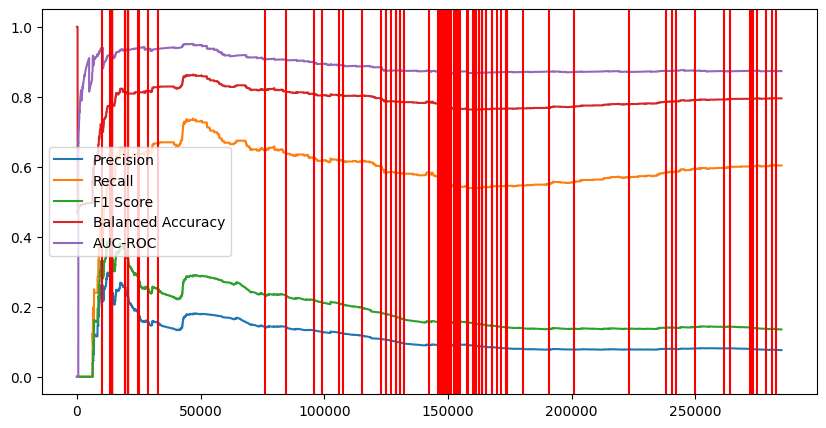

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + Half-Space Trees on the PCA data

In [23]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = PCA_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:26<00:00, 3290.71it/s]

Precision: 3.67
Recall: 22.36
F1 Score: 6.30
Balanced accuracy: 60.67
ROCAUC: 72.92


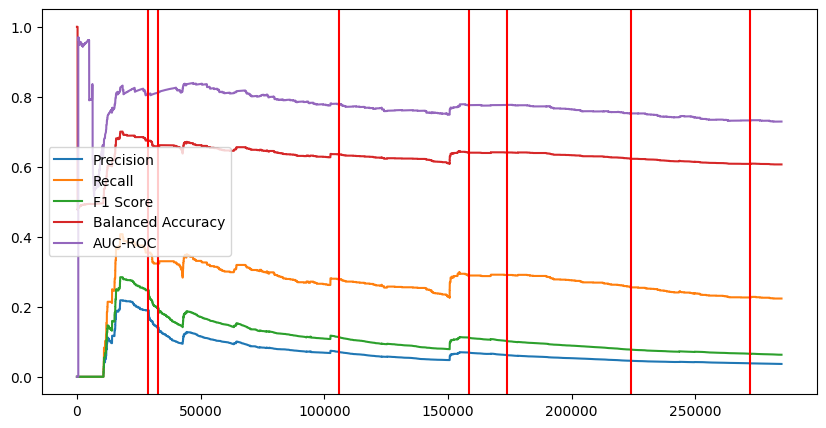

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + Half-Space Trees on the t-SNE data

In [25]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = TSNE_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [03:23<00:00, 1399.00it/s]

Precision: 4.41
Recall: 26.02
F1 Score: 7.54
Balanced accuracy: 62.52
ROCAUC: 68.72


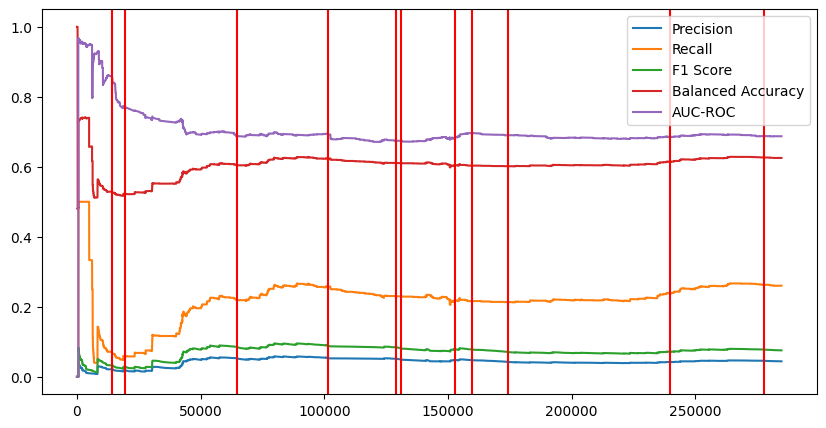

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + Half-Space Trees on the UMAP data

In [27]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.HalfSpaceTrees(
        seed=42,
        n_trees=20,
        height=3,
        window_size=250,
    ),
    q=0.99
)

X = UMAP_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [03:24<00:00, 1389.53it/s]


Precision: 0.70
Recall: 4.27
F1 Score: 1.21
Balanced accuracy: 51.61
ROCAUC: 70.97


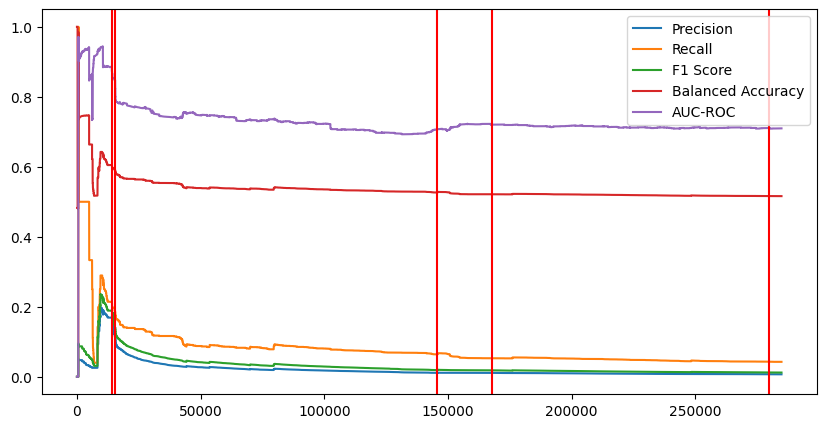

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + One-Class SVM on the original data

In [29]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [02:30<00:00, 1888.80it/s]

Precision: 0.09
Recall: 4.88
F1 Score: 0.18
Balanced accuracy: 47.96
ROCAUC: 50.98


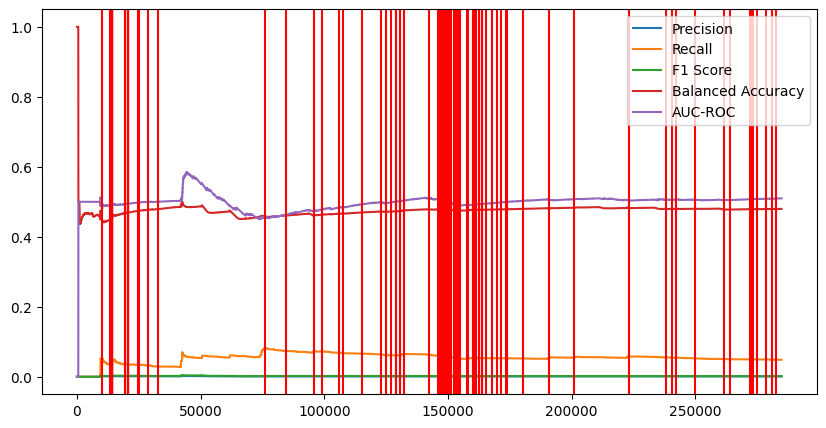

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + One-Class SVM on the PCA data

In [31]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = PCA_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:10<00:00, 4025.89it/s]

Precision: 0.73
Recall: 58.13
F1 Score: 1.44
Balanced accuracy: 72.20
ROCAUC: 50.00


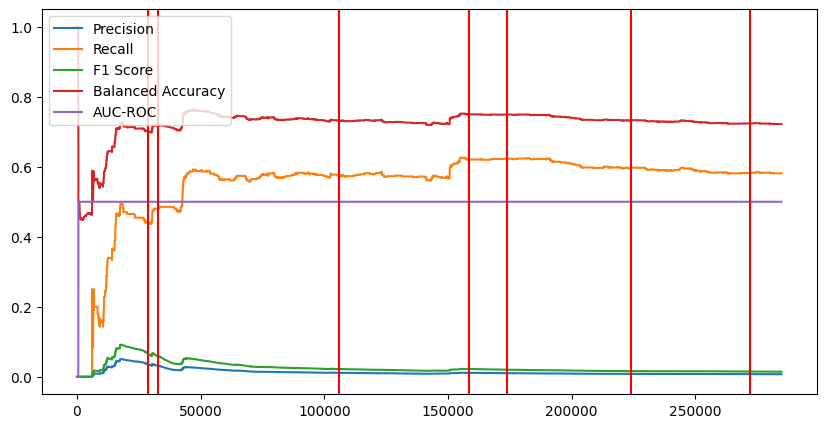

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + One-Class SVM on the t-SNE data

In [33]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = TSNE_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:09<00:00, 4126.61it/s]

Precision: 0.25
Recall: 32.93
F1 Score: 0.49
Balanced accuracy: 55.03
ROCAUC: 49.99


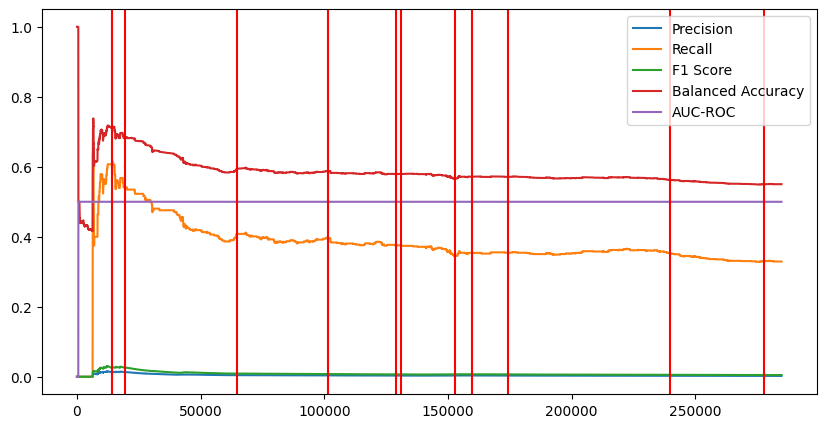

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + One-Class SVM on the UMAP data

In [35]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.OneClassSVM(
        nu=0.001
    ),
    q=0.95
)

X = UMAP_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [01:08<00:00, 4165.02it/s]

Precision: 0.28
Recall: 39.63
F1 Score: 0.55
Balanced accuracy: 57.46
ROCAUC: 47.26


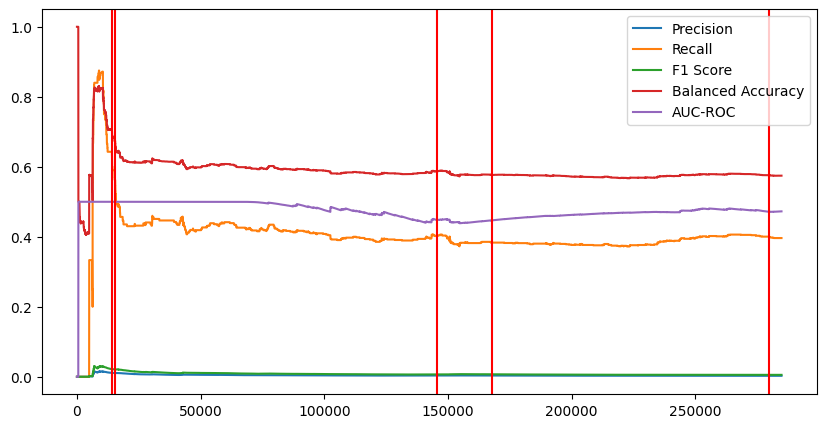

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + Gaussian Scorer on the original data

In [38]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/284807 [00:00<?, ?it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
  0%|          | 239/284807 [00:00<02:00, 2364.87it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
100%|██████████| 284807/284807 [01:31<00:00, 3123.64it/s]


Precision: 49.26
Recall: 88.41
F1 Score: 63.27
Balanced accuracy: 94.13
ROCAUC: 82.13


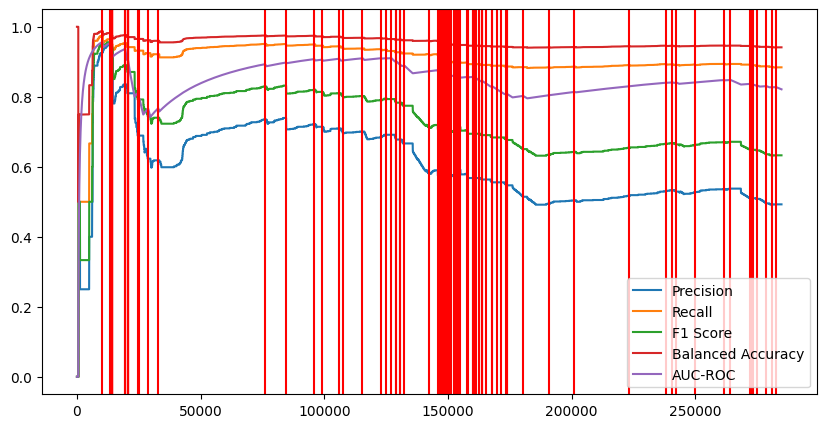

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + Gaussian Scorer on the PCA data

In [41]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = PCA_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/284807 [00:00<?, ?it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
  0%|          | 436/284807 [00:00<01:05, 4358.92it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
100%|██████████| 284807/284807 [00:38<00:00, 7339.52it/s]

Precision: 65.05
Recall: 98.37
F1 Score: 78.32
Balanced accuracy: 99.14
ROCAUC: 95.62


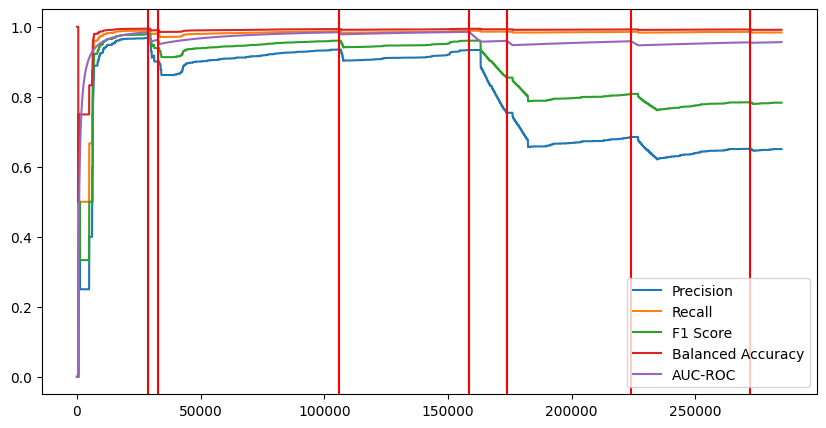

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + Gaussian Scorer on the t-SNE data

In [43]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = TSNE_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

  0%|          | 0/284807 [00:00<?, ?it/s]c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: invalid value encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
c:\Users\34697\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\proba\gaussian.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  return 0.5 * (1.0 + math.erf((x - self.mu) / (self.sigma * math.sqrt(2.0))))
100%|██████████| 284807/284807 [00:39<00:00, 7199.91it/s]

Precision: 61.98
Recall: 97.76
F1 Score: 75.87
Balanced accuracy: 98.83
ROCAUC: 94.61


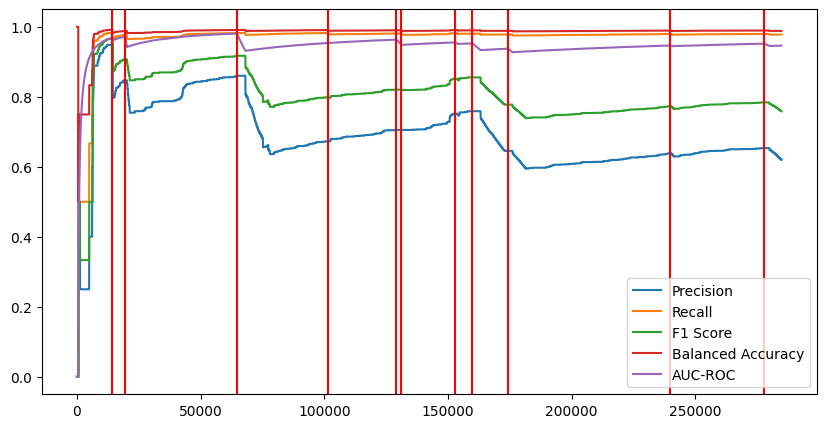

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()

#### ADWIN + Gaussian Scorer on the UMAP data

In [45]:
scaler = preprocessing.MinMaxScaler()
model = anomaly.QuantileFilter(
    anomaly.GaussianScorer(
        window_size=None
    ),
    q=0.99
)

X = UMAP_features.copy()
y = target.copy()

drift_detectors = {feature: drift.ADWIN(delta=1e-10, min_window_length=5000) for feature in X.columns}

metrics_results, drifts_detected = run_and_evaluate_model_with_drift_detectors(scaler, model, drift_detectors, X, y)

print(f"Precision: {metrics_results['precision'][-1]*100:.2f}")
print(f"Recall: {metrics_results['recall'][-1]*100:.2f}")
print(f"F1 Score: {metrics_results['f1'][-1]*100:.2f}")
print(f"Balanced accuracy: {metrics_results['balanced_accuracy'][-1]*100:.2f}")
print(f"ROCAUC: {metrics_results['rocauc'][-1]*100:.2f}")

100%|██████████| 284807/284807 [00:38<00:00, 7333.48it/s]


Precision: 76.78
Recall: 98.78
F1 Score: 86.40
Balanced accuracy: 99.36
ROCAUC: 97.84


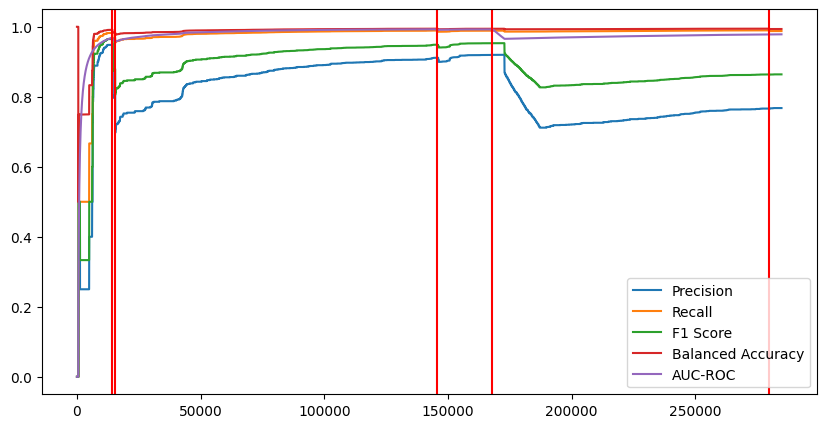

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(metrics_results['precision'], label='Precision')
plt.plot(metrics_results['recall'], label='Recall')
plt.plot(metrics_results['f1'], label='F1 Score')
plt.plot(metrics_results['balanced_accuracy'], label='Balanced Accuracy')
plt.plot(metrics_results['rocauc'], label='AUC-ROC')
for drift_detected in drifts_detected:
    plt.axvline(drift_detected, color='red')
plt.legend()
plt.show()